In [9]:
"""This module contains an abstract class from which L_VGG, T_VGG and V_VGG classes inherit.
    It works as an wrapper class of keras vgg16 class.

    Dev: Caio Moraes
    GitHub: MoraesCaio
    Email: caiomoraes.cesar@gmail.com
"""

import os.path
import glob
import keras
from keras import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np


class VGG16(object):
    """VGG16 interface class

    Attributes:
        con_type (str): Conector type; used as parameter for defining the names of backup files
        db_path (str): Database path used for training
        dict_cls_samples (enum: list): Defect classes and its samples full path list. \n
         These lists are not used anymore. They were used, in previous versions, for file manipulations \n
         such as copy and counting.
        model (keras.engine.training.Model): keras model (fine tuned VGG16)
        model_file (str): Full path for whole model backup file
        paths (list): List of sets path [training, validation, testing]
        side (enum.EnumMeta): One of classification module's enum classes (View, Back or Lateral)
        test_path (str): Full path of directory with testing set.
        train_batch_size (int): Batch size for validation (training)
        train_path (str): Full path of directory with training set.
        tuning_b_file (str): Full path for bias backup file
        tuning_w_file (str): Full path for weights backup file
        valid_batch_size (int): Batch size for validation (training)
        valid_path (str): Full path of directory with validation set.
    """

    # PROPERTIES
    model = None
    dict_cls_samples = None  # dictionary {'CLASS': []}
    side = None  # enum: classification(Lateral, Back or View)
    con_type = ''

    # FOLDERS
    db_path = ''
    train_path = ''
    valid_path = ''
    test_path = ''
    paths = []
    
    sets_size = []

    # BACKUP FILES
    model_file = ''
    tuning_w_file = ''
    tuning_b_file = ''

    # BATCH SIZES
    train_batch_size = 32
    valid_batch_size = 32

    history = None
    
    # GENERATORS
    train_batches = None
    valid_batches = None
    test_batches = None
    
    data_aug_props = None

    def __init__(self, con_type, side):
        """Constructor

        Args:
            con_type (str): Conector type
        """

        self.con_type = con_type
        self.side = side
        self.dict_cls_samples = {k.name: [] for k in self.side}

        # BACKUP
        self.model_file = 'vgg16_' + self.side.__name__ + '_' + con_type + '.h5'
        self.tuning_w_file = 'best_w_' + self.side.__name__ + '_' + con_type + '.npy'
        self.tuning_b_file = 'best_b_' + self.side.__name__ + '_' + con_type + '.npy'

        # BUILDING MODEL
        self.model = keras.applications.vgg16.VGG16()
        self.model = Sequential(self.model.layers[:-1])

        for layer in self.model.layers:
            layer.trainable = False

        self.model.add(Dense(len(self.dict_cls_samples), activation='softmax'))
        self.model.compile(Adam(lr=.0001), loss='categorical_crossentropy',
                           metrics=['accuracy'])

        # RESTORING MODEL
        if os.path.isfile(self.tuning_w_file):
            if os.path.isfile(self.tuning_b_file):
                self.load_vgg_tuning()

    def get_sets_size(self):
        """Count the number of samples for each set

        Returns:
            list: List containg the size of each set [training, validation, testing]
        """
        self.sets_size = [0, 0, 0]

        for i, path in enumerate(self.paths):

            for cl in self.dict_cls_samples:

                cl_count = len(glob.glob(path + cl + '/**/*_' + self.side.__name__ + '*.JPG', recursive=True))
                self.sets_size[i] += cl_count

        return self.sets_size

    def set_db_path(self, db_path):
        """Sets the path for database and its sets

        Args:
            db_path (str): Full path for database
        """

        self.db_path = db_path
        self.train_path = os.path.join(self.db_path, 'train/')
        self.valid_path = os.path.join(self.db_path, 'valid/')
        self.test_path =  os.path.join(self.db_path, 'test/')
        self.paths = [self.train_path, self.valid_path, self.test_path]
        self.get_sets_size()

    def train_model(self, db_path=None, save=True, epochs=400):
        """Train model

        Args:
            db_path (str, optional): Database's full path
            save (bool, optional): If it's True, saves model's weights and biasses

        Returns:
            History.history: Model training history.
        """
        checkpoint_file = 'tmp_weights.hdf5'
        # STOPPING CONDITIONS
        callbacks = [
            # EarlyStopping(monitor='val_loss', patience=4,
            #               mode='min', min_delta=0.001, verbose=1),
            # EarlyStopping(monitor='val_acc', patience=4,
            #               mode='max', min_delta=0.001, verbose=1),
            ModelCheckpoint(checkpoint_file, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=True,
                            mode='auto', period=1),
        ]

        # custom database path
        if db_path is not None:
            self.set_db_path(db_path)

        # ITERATORS
        self.data_aug_props = {
            # 'rotation_range': 10,
            'width_shift_range': 0.02,
            'height_shift_range': 0.01,
            'shear_range': .5,
            'zoom_range': 0.1,
            'brightness_range': [0.7, 1.2],
            # 'channel_shift_range': 10.,
            'horizontal_flip': True
        }

        self.train_batches = ImageDataGenerator(**self.data_aug_props).flow_from_directory(self.train_path,
                                                                                      classes=self.dict_cls_samples,
                                                                                      target_size=(224, 224),
                                                                                      batch_size=self.train_batch_size)
        self.valid_batches = ImageDataGenerator(**self.data_aug_props).flow_from_directory(self.valid_path,
                                                                                      classes=self.dict_cls_samples,
                                                                                      target_size=(224, 224),
                                                                                      batch_size=self.valid_batch_size)
        
        self.test_batches = ImageDataGenerator(**self.data_aug_props).flow_from_directory(self.test_path,
                                                                                          classes=self.dict_cls_samples,
                                                                                          target_size=(224, 224),
                                                                                          batch_size=self.valid_batch_size)
        
        self.history = self.model.fit_generator(self.train_batches,
                                                steps_per_epoch=self.sets_size[0] // self.train_batch_size,
                                                validation_data=self.valid_batches,
                                                validation_steps=self.sets_size[1] // self.valid_batch_size,
                                                use_multiprocessing=True,
                                                epochs=epochs,
                                                callbacks=callbacks,
                                                verbose=2
                                                )
        
        self.model.load_weights(checkpoint_file)
        
        if save:
            self.save_vgg_tuning()


    def predict_image(self, image):
        """Classify one image

        Args:
            image (numpy.array): Image array of the connector

        Returns:
            tuple (str, float): Classification's string and confidence
        """

        sample = np.expand_dims(image, axis=0)
        ar_pred = self.model.predict(sample)
        confidence = float(ar_pred[0, ar_pred.argmax(axis=1)])

        one_hot = np.zeros_like(ar_pred, dtype='int16')
        one_hot[range(len(ar_pred)), ar_pred.argmax()] = 1

        str_cl = sorted(self.dict_cls_samples)[one_hot.flatten().tolist().index(1)]  # index of 1

        return self.side[str_cl], confidence

    def save_vgg(self):
        """Save the whole model with default name file (model_file)
        """

        self.model.save(self.model_file)

    def load_vgg(self):
        """Load the whole model with default name file (model_file)
        """

        self.model = load_model(self.model_file)

    def save_vgg_tuning(self):
        """Save the model's weights and biasses with default name file (tuning_w_file, tuning_b_file)
        """

        w, b = self.model.layers[-1].get_weights()
        np.save(self.tuning_w_file, w)
        np.save(self.tuning_b_file, b)

    def load_vgg_tuning(self):
        """Load the model's weights and biasses with default name file (tuning_w_file, tuning_b_file)
        """

        w = np.load(self.tuning_w_file)
        b = np.load(self.tuning_b_file)
        self.model.layers[-1].set_weights([w, b])


In [10]:
from classification import L


model_l = VGG16('101e', L)
model_l.train_model(db_path='detection_green_L/', save=False)

Found 73 images belonging to 4 classes.
Found 17 images belonging to 4 classes.
Found 26 images belonging to 4 classes.
Epoch 1/400
 - 3s - loss: 2.0363 - acc: 0.1935 - val_loss: 1.8656 - val_acc: 0.3529
Epoch 2/400
 - 1s - loss: 1.6222 - acc: 0.3281 - val_loss: 1.6087 - val_acc: 0.3529
Epoch 3/400
 - 1s - loss: 1.6165 - acc: 0.3105 - val_loss: 1.4545 - val_acc: 0.2941
Epoch 4/400
 - 1s - loss: 1.4132 - acc: 0.3024 - val_loss: 1.2665 - val_acc: 0.5882
Epoch 5/400
 - 1s - loss: 1.1489 - acc: 0.4855 - val_loss: 1.2761 - val_acc: 0.4118
Epoch 6/400
 - 1s - loss: 1.1074 - acc: 0.4844 - val_loss: 1.3094 - val_acc: 0.4706
Epoch 7/400
 - 1s - loss: 1.0933 - acc: 0.6048 - val_loss: 1.3412 - val_acc: 0.4706
Epoch 8/400
 - 1s - loss: 0.9739 - acc: 0.6094 - val_loss: 1.1713 - val_acc: 0.4706
Epoch 9/400
 - 1s - loss: 1.0221 - acc: 0.5968 - val_loss: 1.1868 - val_acc: 0.4118
Epoch 10/400
 - 1s - loss: 0.9529 - acc: 0.5782 - val_loss: 1.0942 - val_acc: 0.5294
Epoch 11/400
 - 1s - loss: 0.9315 - acc

 - 1s - loss: 0.2461 - acc: 0.9219 - val_loss: 0.6838 - val_acc: 0.5882
Epoch 97/400
 - 1s - loss: 0.2205 - acc: 0.9548 - val_loss: 0.5930 - val_acc: 0.7647
Epoch 98/400
 - 1s - loss: 0.1728 - acc: 1.0000 - val_loss: 0.5764 - val_acc: 0.7059
Epoch 99/400
 - 1s - loss: 0.2208 - acc: 1.0000 - val_loss: 0.6353 - val_acc: 0.7059
Epoch 100/400
 - 1s - loss: 0.2036 - acc: 0.9548 - val_loss: 0.7356 - val_acc: 0.5882
Epoch 101/400
 - 1s - loss: 0.2459 - acc: 0.9531 - val_loss: 0.5370 - val_acc: 0.6471
Epoch 102/400
 - 1s - loss: 0.2042 - acc: 0.9815 - val_loss: 0.6200 - val_acc: 0.5882
Epoch 103/400
 - 1s - loss: 0.1939 - acc: 1.0000 - val_loss: 0.4183 - val_acc: 0.8235
Epoch 104/400
 - 1s - loss: 0.2198 - acc: 0.9531 - val_loss: 0.6541 - val_acc: 0.6471
Epoch 105/400
 - 1s - loss: 0.1934 - acc: 1.0000 - val_loss: 0.5408 - val_acc: 0.7059
Epoch 106/400
 - 1s - loss: 0.2935 - acc: 0.9258 - val_loss: 0.7271 - val_acc: 0.5882
Epoch 107/400
 - 1s - loss: 0.1804 - acc: 1.0000 - val_loss: 0.6326 - v

Epoch 192/400
 - 1s - loss: 0.0844 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.5882
Epoch 193/400
 - 1s - loss: 0.1209 - acc: 1.0000 - val_loss: 0.5795 - val_acc: 0.7647
Epoch 194/400
 - 1s - loss: 0.1065 - acc: 1.0000 - val_loss: 0.6237 - val_acc: 0.7059
Epoch 195/400
 - 1s - loss: 0.1076 - acc: 1.0000 - val_loss: 0.5698 - val_acc: 0.7647
Epoch 196/400
 - 1s - loss: 0.0949 - acc: 1.0000 - val_loss: 0.5518 - val_acc: 0.7647
Epoch 197/400
 - 1s - loss: 0.0965 - acc: 1.0000 - val_loss: 0.5034 - val_acc: 0.7059
Epoch 198/400
 - 1s - loss: 0.1601 - acc: 0.9531 - val_loss: 0.7158 - val_acc: 0.7059
Epoch 199/400
 - 1s - loss: 0.1227 - acc: 0.9815 - val_loss: 0.4455 - val_acc: 0.7647
Epoch 200/400
 - 1s - loss: 0.1196 - acc: 0.9844 - val_loss: 0.5002 - val_acc: 0.7647
Epoch 201/400
 - 1s - loss: 0.1568 - acc: 0.9548 - val_loss: 0.5375 - val_acc: 0.7059
Epoch 202/400
 - 1s - loss: 0.1398 - acc: 0.9815 - val_loss: 0.4247 - val_acc: 0.8235
Epoch 203/400
 - 1s - loss: 0.1409 - acc: 0.9688 - val

Epoch 288/400
 - 1s - loss: 0.1105 - acc: 0.9688 - val_loss: 0.3802 - val_acc: 0.7647
Epoch 289/400
 - 1s - loss: 0.0804 - acc: 0.9844 - val_loss: 0.6388 - val_acc: 0.7059
Epoch 290/400
 - 1s - loss: 0.1014 - acc: 1.0000 - val_loss: 0.5017 - val_acc: 0.7059
Epoch 291/400
 - 1s - loss: 0.0570 - acc: 1.0000 - val_loss: 0.4294 - val_acc: 0.8235
Epoch 292/400
 - 1s - loss: 0.0857 - acc: 1.0000 - val_loss: 0.6571 - val_acc: 0.6471
Epoch 293/400
 - 1s - loss: 0.0840 - acc: 1.0000 - val_loss: 0.5093 - val_acc: 0.7059
Epoch 294/400
 - 1s - loss: 0.0796 - acc: 1.0000 - val_loss: 0.5481 - val_acc: 0.6471
Epoch 295/400
 - 1s - loss: 0.0740 - acc: 1.0000 - val_loss: 0.4910 - val_acc: 0.7647
Epoch 296/400
 - 1s - loss: 0.1394 - acc: 1.0000 - val_loss: 0.3569 - val_acc: 0.9412
Epoch 297/400
 - 1s - loss: 0.0844 - acc: 1.0000 - val_loss: 0.4087 - val_acc: 0.7647
Epoch 298/400
 - 1s - loss: 0.0694 - acc: 1.0000 - val_loss: 0.4521 - val_acc: 0.8235
Epoch 299/400
 - 1s - loss: 0.0649 - acc: 0.9815 - val

Epoch 384/400
 - 1s - loss: 0.0822 - acc: 1.0000 - val_loss: 0.4686 - val_acc: 0.8824
Epoch 385/400
 - 1s - loss: 0.0765 - acc: 1.0000 - val_loss: 0.4717 - val_acc: 0.7059
Epoch 386/400
 - 1s - loss: 0.0770 - acc: 0.9844 - val_loss: 0.4842 - val_acc: 0.7647
Epoch 387/400
 - 1s - loss: 0.0426 - acc: 1.0000 - val_loss: 0.4555 - val_acc: 0.8824
Epoch 388/400
 - 1s - loss: 0.0826 - acc: 0.9688 - val_loss: 0.4077 - val_acc: 0.7059
Epoch 389/400
 - 1s - loss: 0.0577 - acc: 1.0000 - val_loss: 0.5289 - val_acc: 0.7647
Epoch 390/400
 - 1s - loss: 0.0888 - acc: 0.9531 - val_loss: 0.5255 - val_acc: 0.6471
Epoch 391/400
 - 1s - loss: 0.0830 - acc: 0.9844 - val_loss: 0.5290 - val_acc: 0.7059
Epoch 392/400
 - 1s - loss: 0.0233 - acc: 1.0000 - val_loss: 0.3640 - val_acc: 0.8235
Epoch 393/400
 - 1s - loss: 0.0587 - acc: 1.0000 - val_loss: 0.6262 - val_acc: 0.7059
Epoch 394/400
 - 1s - loss: 0.0493 - acc: 1.0000 - val_loss: 0.4339 - val_acc: 0.7647
Epoch 395/400
 - 1s - loss: 0.0560 - acc: 1.0000 - val

In [3]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plots(ims, figsize=(70, 70), cols=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    rows = len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=42)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

def print_results(model, batch_generator, print_cm=True, print_errors=True, print_success=False):
    imgs, labels = next(batch_generator)
    labels_max = labels.argmax(axis=-1)

    predictions = model.model.predict_on_batch(imgs)
    predictions_max = predictions.argmax(axis=-1)

    cm = confusion_matrix(labels_max, predictions_max)
    plot_confusion_matrix(cm, model.dict_cls_samples.keys())

    diffs, titles_diff = [], []
    success, titles_success = [], []
    print('Total:', len(imgs))
    sorted_classes = sorted(model.dict_cls_samples)
    for i in range(len(imgs)):
        if print_errors and predictions_max[i] != labels_max[i]:
            error_title = model.side[sorted_classes[predictions_max[i]]]
            success_title = model.side[sorted_classes[labels_max[i]]]
            titles_diff.append(f'{error_title}\nTrue: {success_title}')
            diffs.append(imgs[i])
        elif print_success and predictions_max[i] == labels_max[i]:
            success_title = model.side[sorted_classes[predictions_max[i]]]
            titles_success.append(f'{success_title}')
            success.append(imgs[i])

    if diffs:
        plots(diffs, cols=5, titles=titles_diff)
    if success:
        plots(success, cols=5, titles=titles_success)


<h1>Lateral 100 épocas (BTS, PMC, SD & TMP) - sem translação</h1>

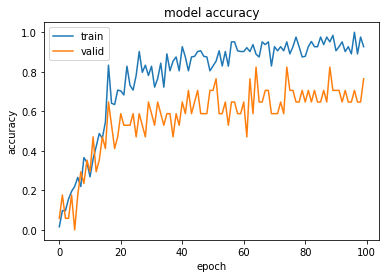

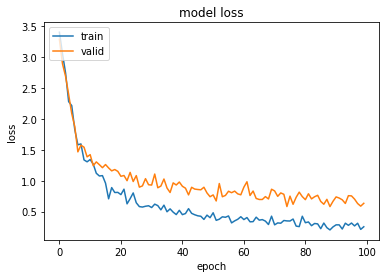

In [4]:
plot_history(model_l.history)

Confusion matrix, without normalization
Total: 17


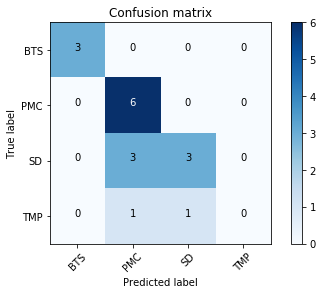

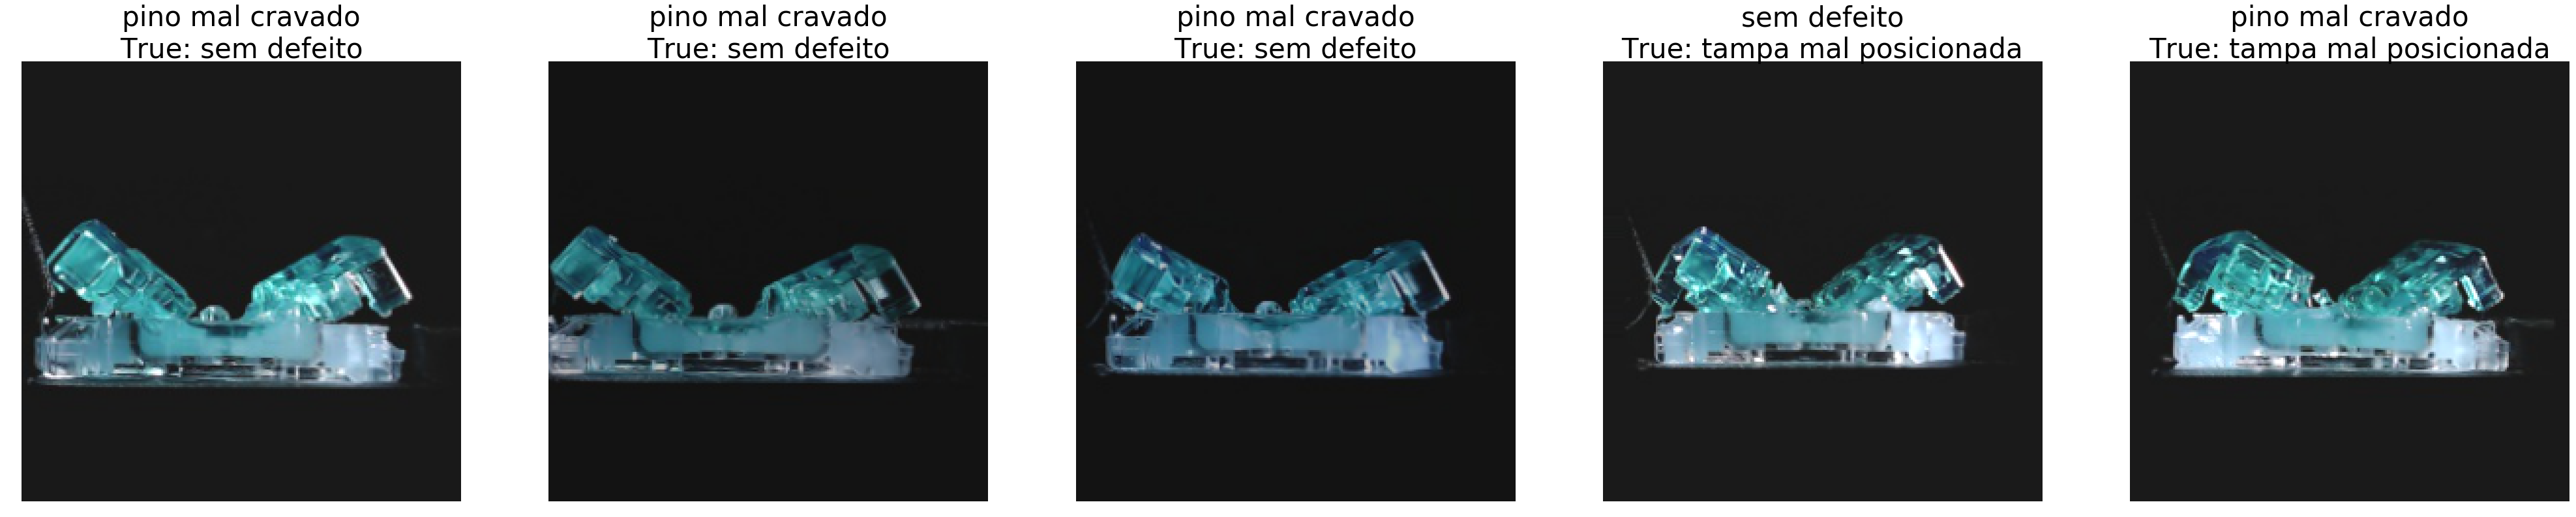

In [7]:
print_results(model_l, model_l.valid_batches)

Confusion matrix, without normalization
Total: 26


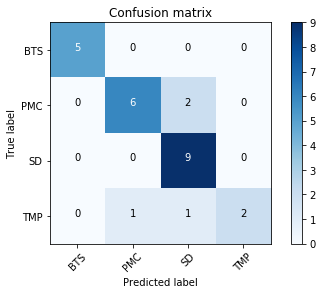

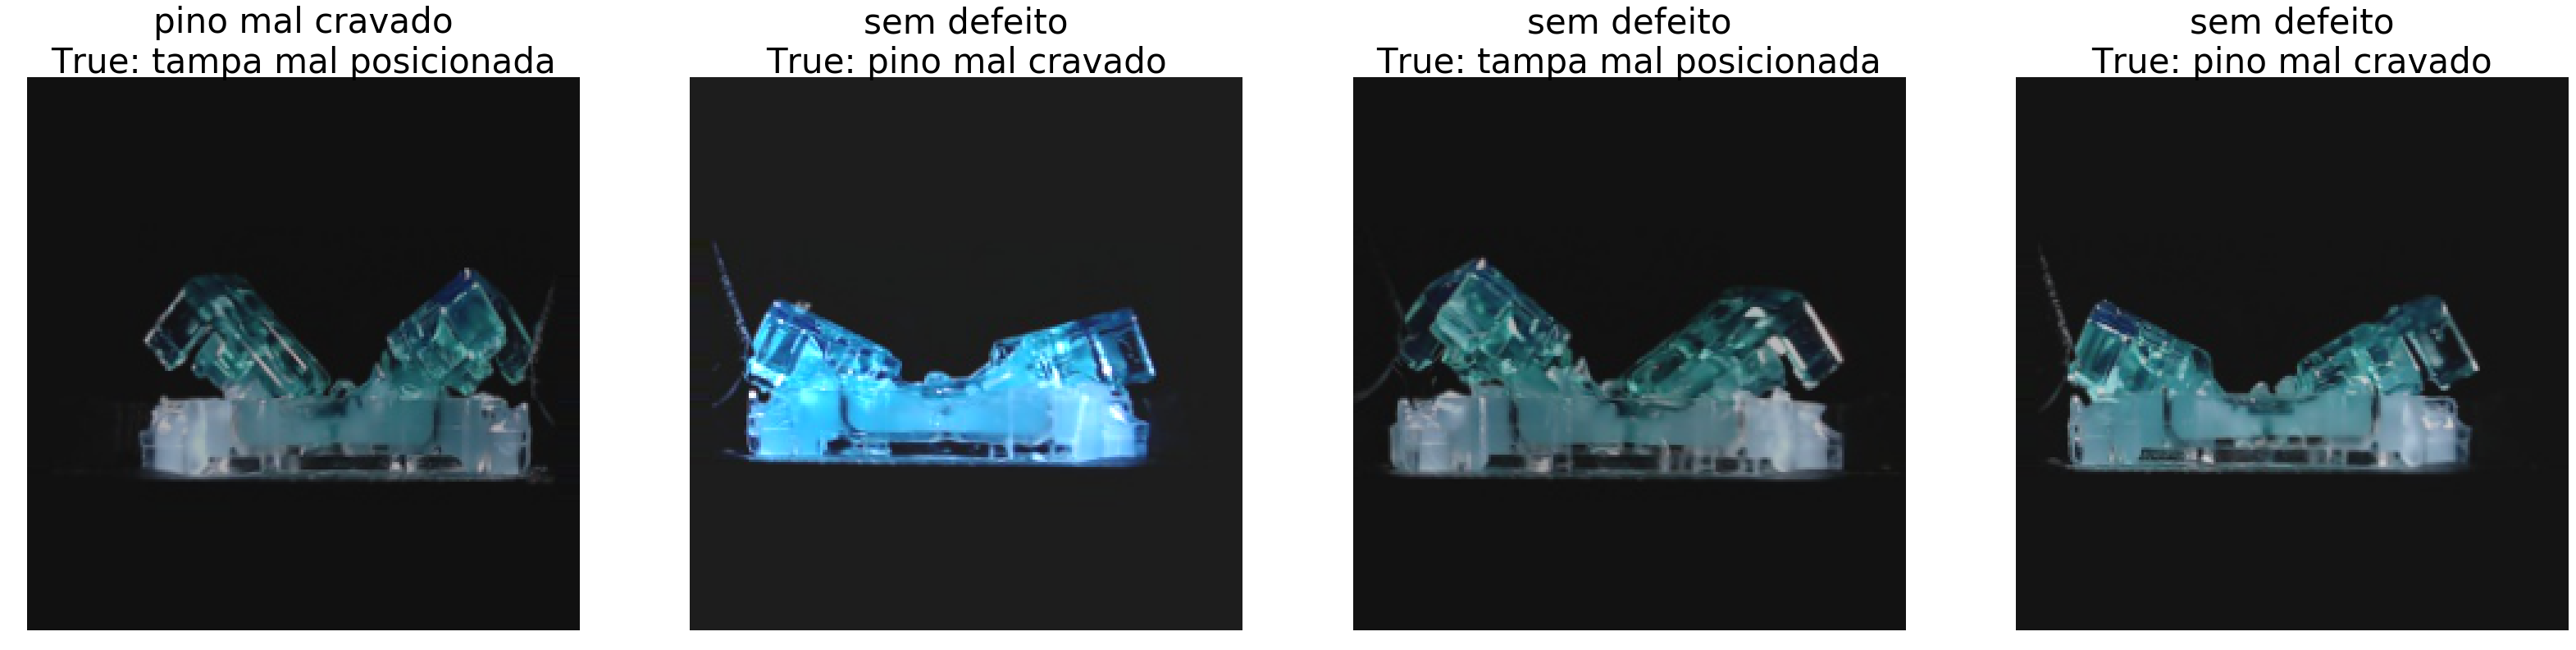

In [5]:
print_results(model_l, model_l.test_batches)

<h1>Lateral 100 épocas (BTS, PMC, SD & TMP) - com translação</h1>

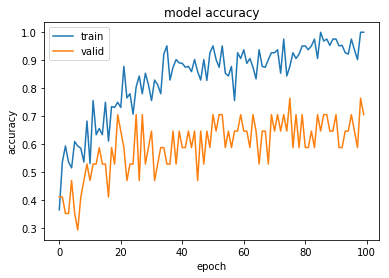

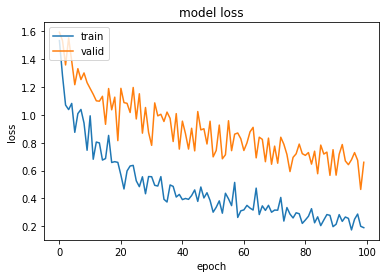

In [4]:
plot_history(model_l.history)

Confusion matrix, without normalization
Total: 17


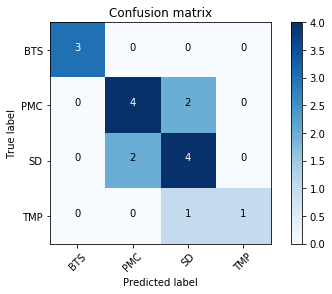

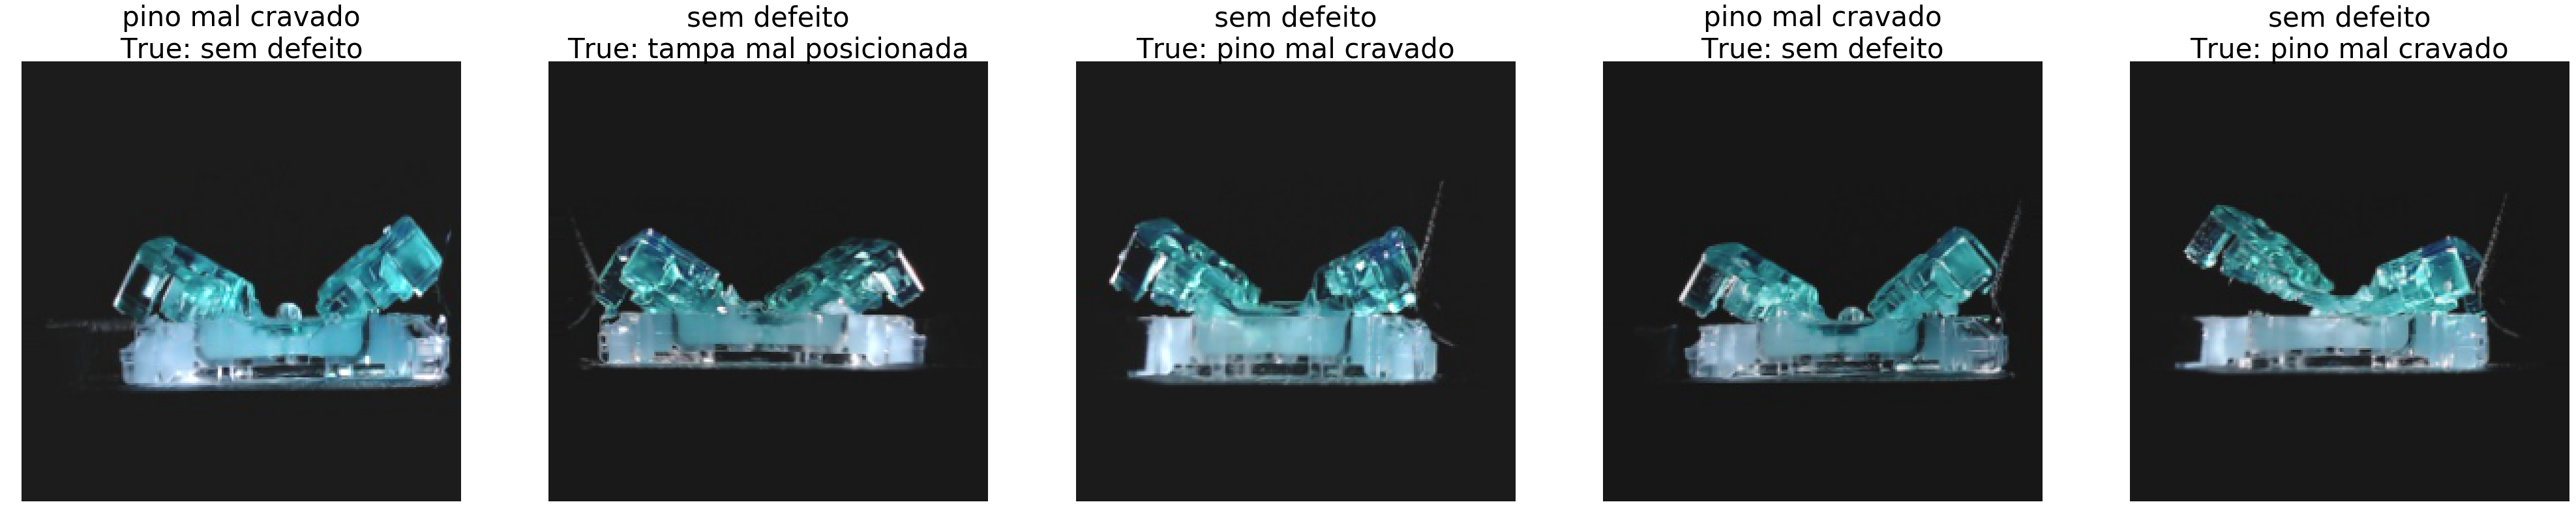

In [8]:
print_results(model_l, model_l.valid_batches)

Confusion matrix, without normalization
Total: 26


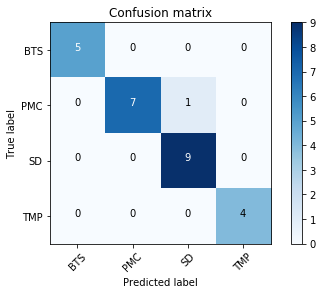

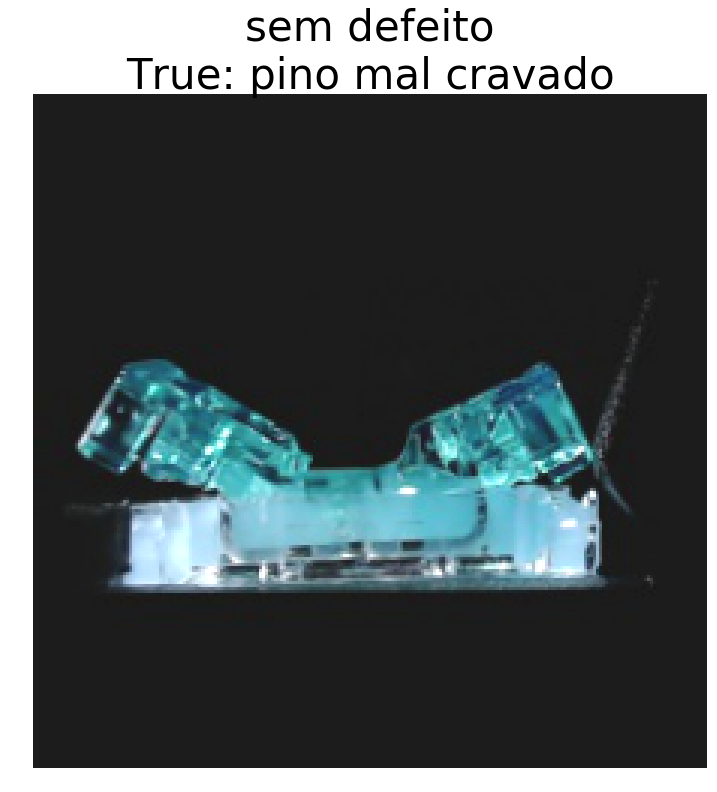

In [6]:
print_results(model_l, model_l.test_batches)

<h1>Lateral 400 épocas (BTS, PMC, SD & TMP) - com translação</h1>

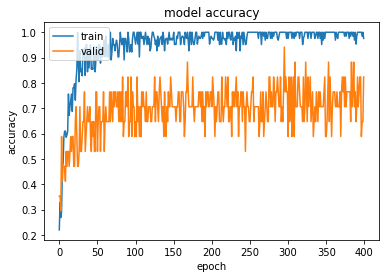

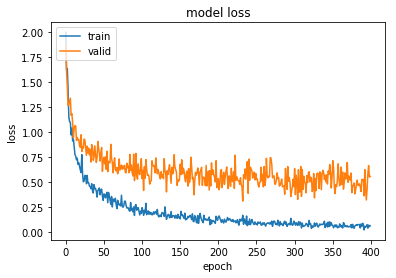

In [11]:
plot_history(model_l.history)

Confusion matrix, without normalization
Total: 17


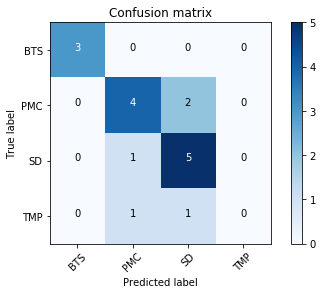

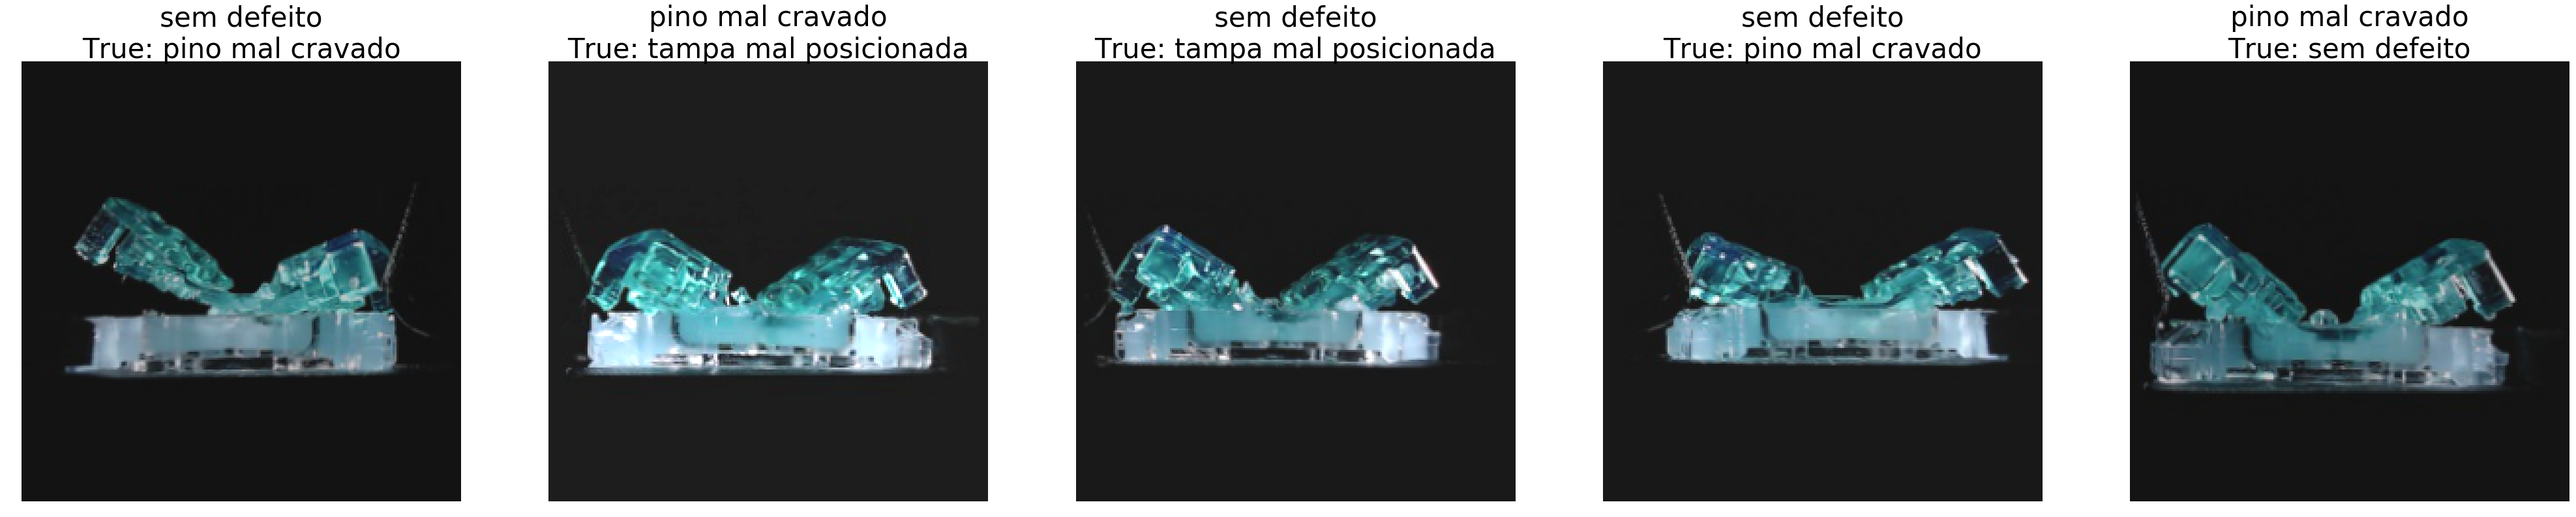

In [12]:
print_results(model_l, model_l.valid_batches)

In [1]:
print_results(model_l, model_l.test_batches)

NameError: name 'print_results' is not defined

<h1>TRASEIRA 400 épocas (AC, CMP, DS & SD) - com translação</h1>

In [14]:
from classification import T


model_t = VGG16('101e', T)
model_t.train_model(db_path='detection_green_T/', save=False)

Found 48 images belonging to 4 classes.
Found 12 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/400
 - 12s - loss: 2.3085 - acc: 0.1250 - val_loss: 2.0320 - val_acc: 0.1667
Epoch 2/400
 - 2s - loss: 2.1732 - acc: 0.3125 - val_loss: 1.8744 - val_acc: 0.0833
Epoch 3/400
 - 0s - loss: 1.8793 - acc: 0.1875 - val_loss: 1.9440 - val_acc: 0.2500
Epoch 4/400
 - 1s - loss: 1.9234 - acc: 0.1250 - val_loss: 1.7152 - val_acc: 0.2500
Epoch 5/400
 - 0s - loss: 1.6235 - acc: 0.3125 - val_loss: 1.6733 - val_acc: 0.2500
Epoch 6/400
 - 1s - loss: 1.7835 - acc: 0.1562 - val_loss: 1.7075 - val_acc: 0.1667
Epoch 7/400
 - 1s - loss: 1.7220 - acc: 0.3125 - val_loss: 1.6578 - val_acc: 0.2500
Epoch 8/400
 - 0s - loss: 1.6347 - acc: 0.2500 - val_loss: 1.3685 - val_acc: 0.4167
Epoch 9/400
 - 0s - loss: 1.6954 - acc: 0.1250 - val_loss: 1.6607 - val_acc: 0.1667
Epoch 10/400
 - 1s - loss: 1.5361 - acc: 0.2812 - val_loss: 1.5775 - val_acc: 0.2500
Epoch 11/400
 - 1s - loss: 1.5779 - ac

 - 0s - loss: 0.4516 - acc: 0.8750 - val_loss: 0.7040 - val_acc: 0.7500
Epoch 97/400
 - 1s - loss: 0.4915 - acc: 0.9688 - val_loss: 0.6664 - val_acc: 0.9167
Epoch 98/400
 - 0s - loss: 0.5027 - acc: 0.9375 - val_loss: 0.7920 - val_acc: 0.5833
Epoch 99/400
 - 1s - loss: 0.4957 - acc: 0.9062 - val_loss: 0.6675 - val_acc: 0.8333
Epoch 100/400
 - 0s - loss: 0.4836 - acc: 0.8750 - val_loss: 0.8254 - val_acc: 0.6667
Epoch 101/400
 - 0s - loss: 0.6240 - acc: 0.8125 - val_loss: 0.8592 - val_acc: 0.5833
Epoch 102/400
 - 1s - loss: 0.4898 - acc: 1.0000 - val_loss: 0.7222 - val_acc: 0.6667
Epoch 103/400
 - 1s - loss: 0.4791 - acc: 0.9375 - val_loss: 0.6570 - val_acc: 0.8333
Epoch 104/400
 - 0s - loss: 0.6299 - acc: 0.8750 - val_loss: 0.6584 - val_acc: 0.8333
Epoch 105/400
 - 0s - loss: 0.7974 - acc: 0.8125 - val_loss: 0.7219 - val_acc: 0.7500
Epoch 106/400
 - 1s - loss: 0.3620 - acc: 0.9688 - val_loss: 0.7112 - val_acc: 0.8333
Epoch 107/400
 - 1s - loss: 0.5063 - acc: 0.8750 - val_loss: 0.7088 - v

Epoch 192/400
 - 1s - loss: 0.2630 - acc: 0.9688 - val_loss: 0.5844 - val_acc: 0.7500
Epoch 193/400
 - 1s - loss: 0.3194 - acc: 0.9062 - val_loss: 0.5426 - val_acc: 0.8333
Epoch 194/400
 - 0s - loss: 0.2689 - acc: 1.0000 - val_loss: 0.5330 - val_acc: 0.7500
Epoch 195/400
 - 1s - loss: 0.2747 - acc: 0.9688 - val_loss: 0.5695 - val_acc: 0.7500
Epoch 196/400
 - 0s - loss: 0.3265 - acc: 1.0000 - val_loss: 0.5870 - val_acc: 0.8333
Epoch 197/400
 - 0s - loss: 0.2785 - acc: 1.0000 - val_loss: 0.5670 - val_acc: 0.7500
Epoch 198/400
 - 1s - loss: 0.3339 - acc: 0.9375 - val_loss: 0.5099 - val_acc: 0.9167
Epoch 199/400
 - 1s - loss: 0.3260 - acc: 0.9375 - val_loss: 0.5801 - val_acc: 0.8333
Epoch 200/400
 - 0s - loss: 0.3697 - acc: 0.9375 - val_loss: 0.6550 - val_acc: 0.7500
Epoch 201/400
 - 0s - loss: 0.3247 - acc: 1.0000 - val_loss: 0.6059 - val_acc: 0.7500
Epoch 202/400
 - 1s - loss: 0.2351 - acc: 1.0000 - val_loss: 0.6103 - val_acc: 0.7500
Epoch 203/400
 - 1s - loss: 0.2963 - acc: 0.9062 - val

Epoch 288/400
 - 1s - loss: 0.1991 - acc: 0.9688 - val_loss: 0.4677 - val_acc: 0.8333
Epoch 289/400
 - 1s - loss: 0.1594 - acc: 1.0000 - val_loss: 0.5267 - val_acc: 0.7500
Epoch 290/400
 - 0s - loss: 0.1623 - acc: 1.0000 - val_loss: 0.6365 - val_acc: 0.7500
Epoch 291/400
 - 0s - loss: 0.2286 - acc: 1.0000 - val_loss: 0.7100 - val_acc: 0.5833
Epoch 292/400
 - 1s - loss: 0.2209 - acc: 0.9375 - val_loss: 0.5052 - val_acc: 0.9167
Epoch 293/400
 - 1s - loss: 0.2106 - acc: 0.9062 - val_loss: 0.7705 - val_acc: 0.5833
Epoch 294/400
 - 0s - loss: 0.2131 - acc: 0.9375 - val_loss: 0.7341 - val_acc: 0.7500
Epoch 295/400
 - 0s - loss: 0.2325 - acc: 0.9375 - val_loss: 0.4909 - val_acc: 0.9167
Epoch 296/400
 - 1s - loss: 0.2139 - acc: 0.9688 - val_loss: 0.6096 - val_acc: 0.7500
Epoch 297/400
 - 0s - loss: 0.1205 - acc: 1.0000 - val_loss: 0.6143 - val_acc: 0.8333
Epoch 298/400
 - 1s - loss: 0.1760 - acc: 1.0000 - val_loss: 0.5265 - val_acc: 0.7500
Epoch 299/400
 - 0s - loss: 0.2290 - acc: 0.9375 - val

Epoch 384/400
 - 1s - loss: 0.1775 - acc: 0.9688 - val_loss: 0.6739 - val_acc: 0.7500
Epoch 385/400
 - 0s - loss: 0.1165 - acc: 1.0000 - val_loss: 0.5027 - val_acc: 0.8333
Epoch 386/400
 - 1s - loss: 0.1446 - acc: 0.9688 - val_loss: 0.4846 - val_acc: 0.7500
Epoch 387/400
 - 0s - loss: 0.1724 - acc: 1.0000 - val_loss: 0.5598 - val_acc: 0.7500
Epoch 388/400
 - 1s - loss: 0.1428 - acc: 1.0000 - val_loss: 0.6493 - val_acc: 0.7500
Epoch 389/400
 - 1s - loss: 0.1271 - acc: 1.0000 - val_loss: 0.6136 - val_acc: 0.6667
Epoch 390/400
 - 0s - loss: 0.1390 - acc: 0.9375 - val_loss: 0.5012 - val_acc: 0.6667
Epoch 391/400
 - 0s - loss: 0.1365 - acc: 1.0000 - val_loss: 0.5442 - val_acc: 0.6667
Epoch 392/400
 - 1s - loss: 0.1155 - acc: 1.0000 - val_loss: 0.5475 - val_acc: 0.7500
Epoch 393/400
 - 0s - loss: 0.1431 - acc: 1.0000 - val_loss: 0.6497 - val_acc: 0.6667
Epoch 394/400
 - 1s - loss: 0.1095 - acc: 1.0000 - val_loss: 0.6499 - val_acc: 0.8333
Epoch 395/400
 - 0s - loss: 0.1852 - acc: 1.0000 - val

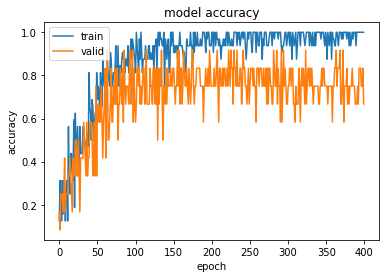

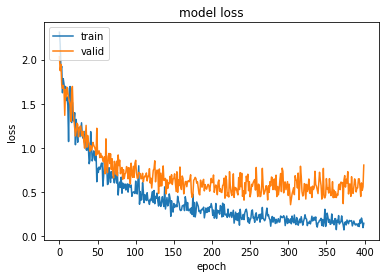

In [15]:
plot_history(model_t.history)

Confusion matrix, without normalization
Total: 12


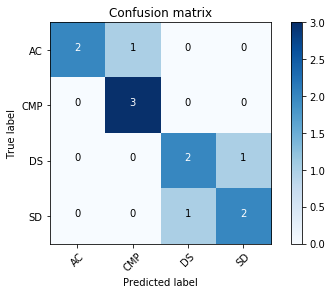

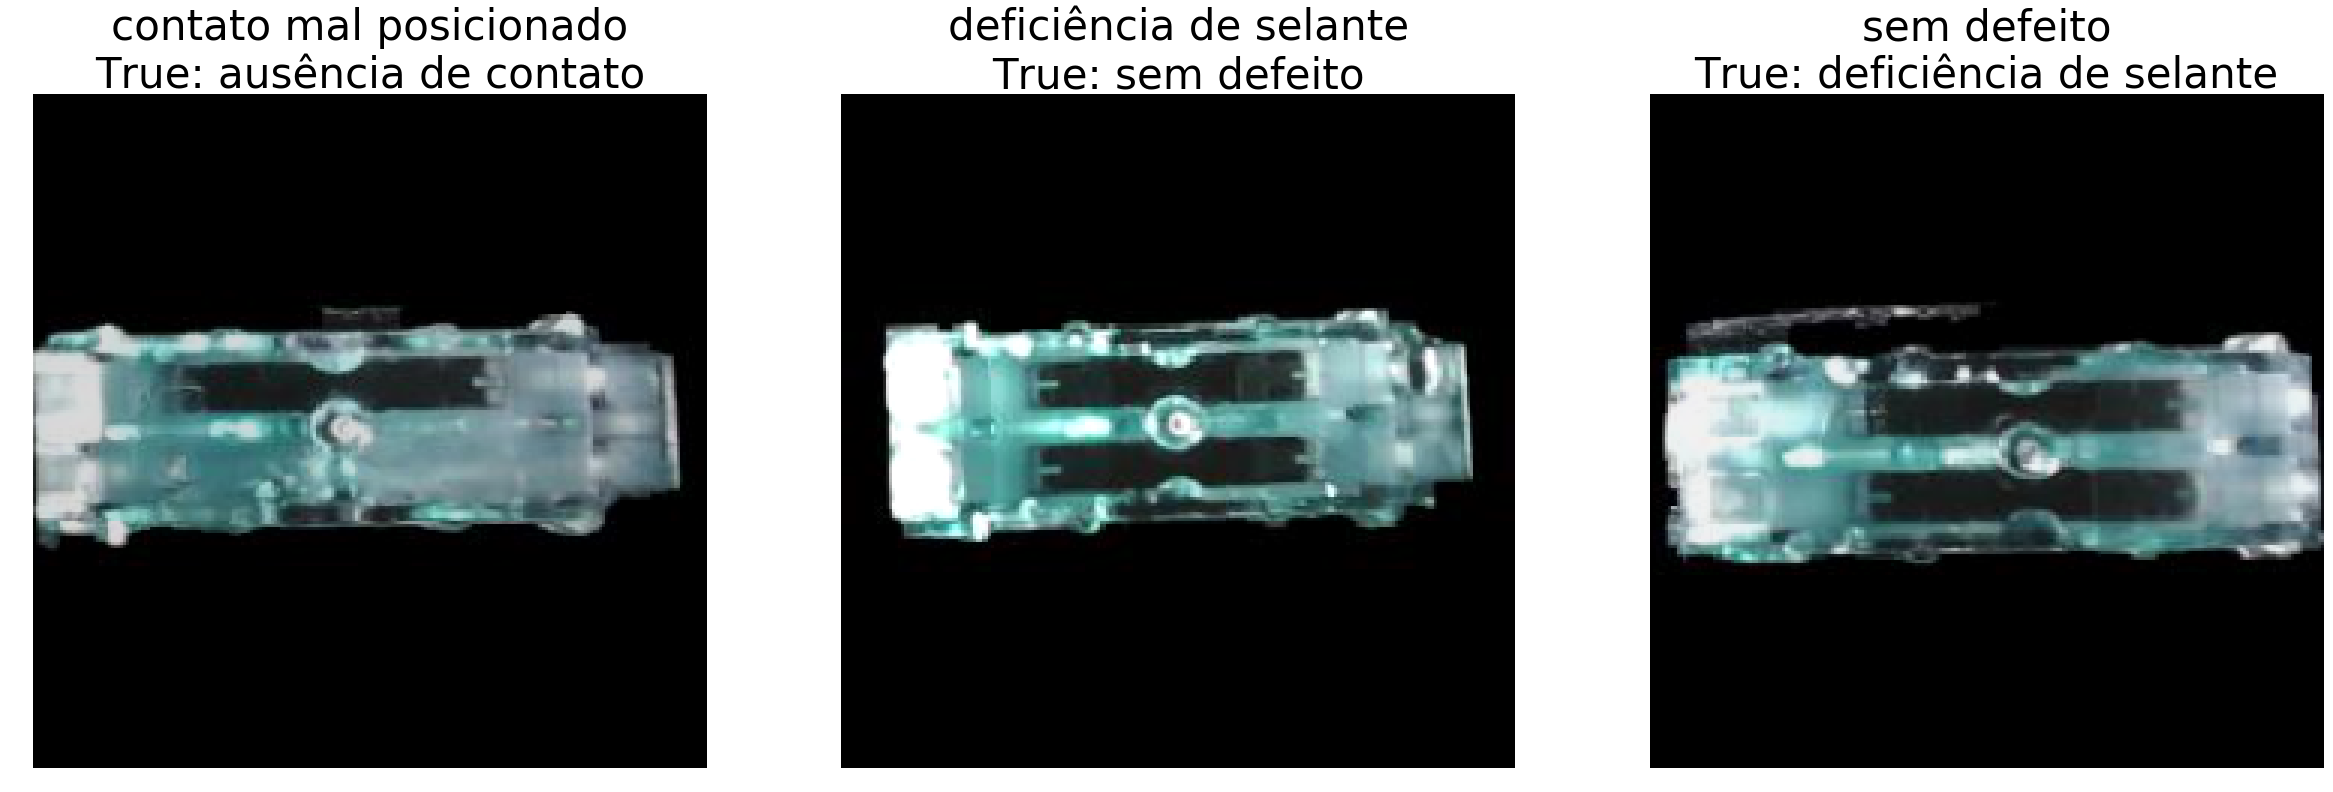

In [16]:
print_results(model_t, model_t.valid_batches)

Confusion matrix, without normalization
Total: 20


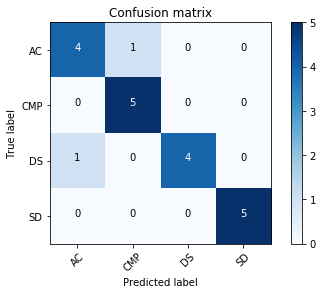

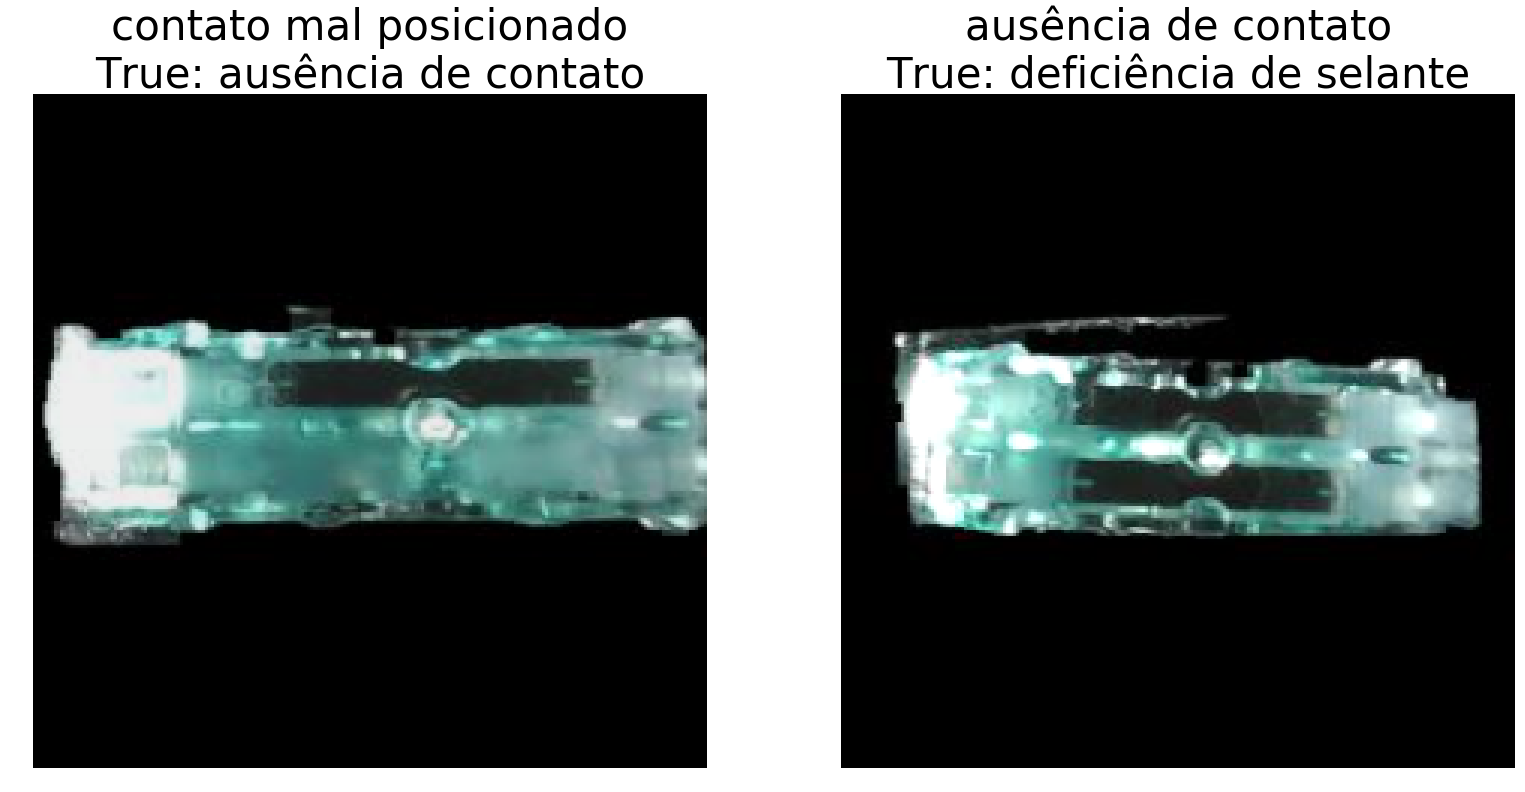

In [17]:
print_results(model_t, model_t.test_batches)